In [1]:
import os
import pandas as pd
from influxdb_client import InfluxDBClient

# Connection to InfluxDB
client = InfluxDBClient(
    url=os.getenv("INFLUX_URL"),
    token=os.getenv("INFLUX_TOKEN"),
    org=os.getenv("INFLUX_ORG"),
)
query_api = client.query_api()
bucket = os.getenv("INFLUX_BUCKET")

# Query all sensors for last hour
query = f'''
from(bucket:"{bucket}")
|> range(start: -1h)
|> filter(fn: (r) => r._measurement == "rig_measurements")
'''

result = query_api.query(org=os.getenv("INFLUX_ORG"), query=query)

# Convert to df
data = []
for table in result:
    for record in table.records:
        data.append(
            {
                "rig_id": record["rig_id"],
                "timestamp": record["_time"],
                "sensor": record["_field"],
                "value": record["_value"],
            }
        )

df_vert = pd.DataFrame(data)

# Pivot в горизонтальный формат
df_horizontal = df_vert.pivot_table(
    index=["rig_id", "timestamp"], columns="sensor", values="value"
).reset_index()

df_horizontal.head()

sensor,rig_id,timestamp,current,flow_rate,pressure,temp_inlet,temp_outlet,voltage
0,RIG-1,2025-11-02 08:39:14+00:00,NaN,NaN,NaN,61.34,NaN,NaN
1,RIG-1,2025-11-02 08:39:15+00:00,32.60,78.93,80.54,NaN,60.54,99.05
2,RIG-1,2025-11-02 08:39:18+00:00,NaN,NaN,45.07,50.11,55.72,NaN
3,RIG-1,2025-11-02 08:39:19+00:00,29.45,87.84,NaN,NaN,NaN,75.01
4,RIG-1,2025-11-02 08:39:20+00:00,96.96,65.81,15.32,76.22,91.89,45.62


In [2]:
df = df_horizontal

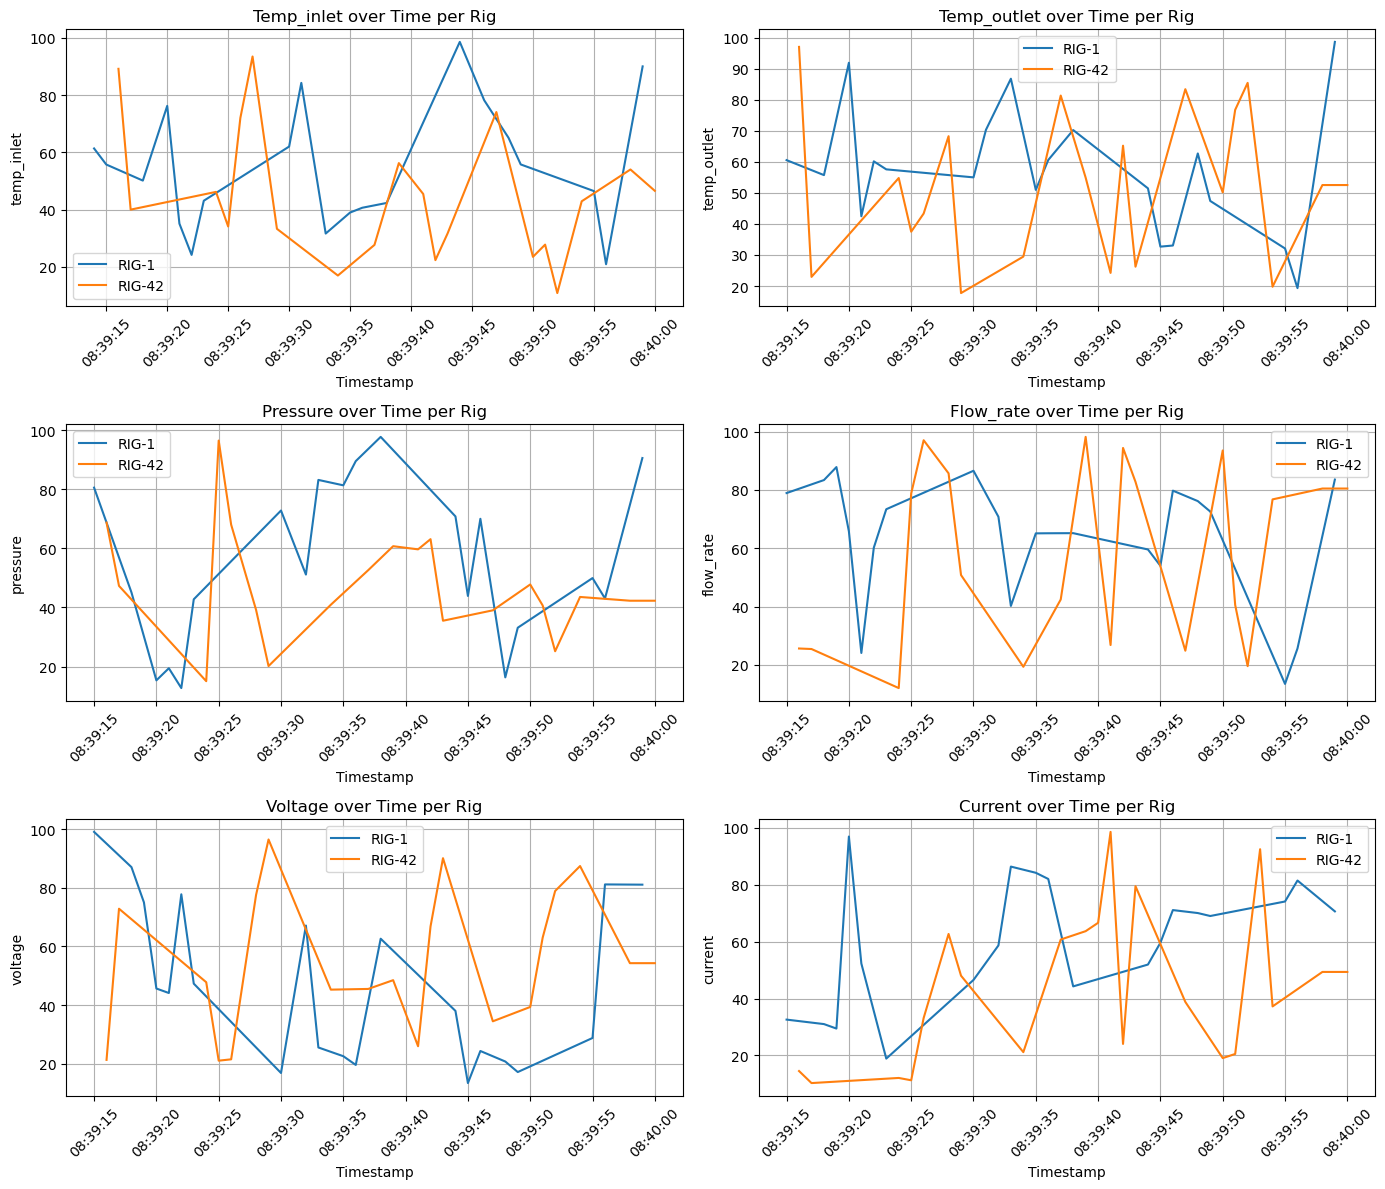

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

df['timestamp'] = pd.to_datetime(df['timestamp'])

sensors = ["temp_inlet", "temp_outlet", "pressure", "flow_rate", "voltage", "current"]
n_cols = 2
n_rows = (len(sensors) + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 4), sharex=False)
axes = axes.flatten()

for i, sensor in enumerate(sensors):
    ax = axes[i]
    for rig, group in df.groupby('rig_id'):
        group_sorted = group.sort_values('timestamp')
        interp_values = group_sorted[sensor].interpolate()
        ax.plot(group_sorted['timestamp'], interp_values, label=rig)
    
    ax.set_title(f'{sensor.capitalize()} over Time per Rig')
    ax.set_xlabel('Timestamp')
    ax.set_ylabel(sensor)
    ax.grid(True)
    ax.legend()
    ax.tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

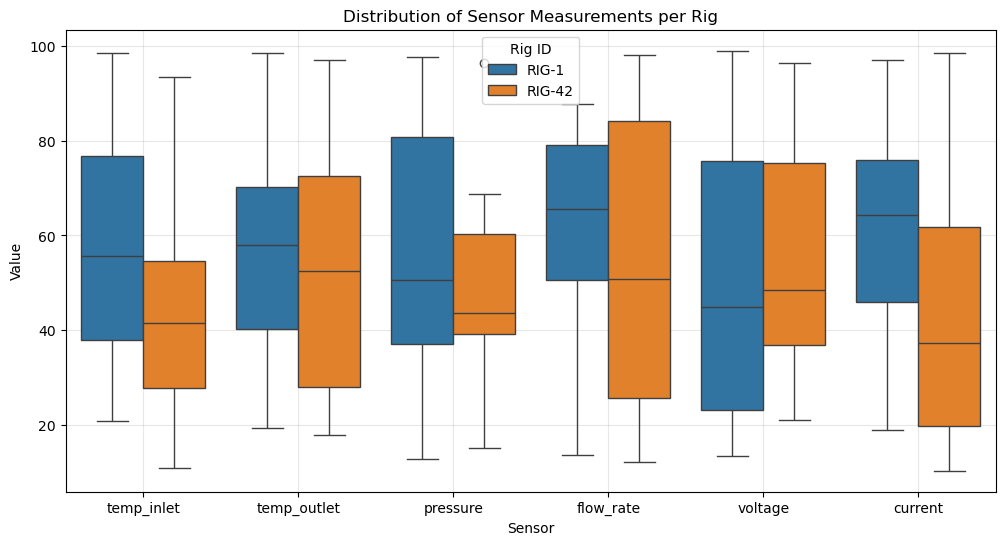

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sensors = ['temp_inlet', 'temp_outlet', 'pressure', 'flow_rate', 'voltage', 'current']

df_melted = df.melt(
    id_vars=['rig_id', 'timestamp'],
    value_vars=sensors,
    var_name='sensor',
    value_name='value'
)

plt.figure(figsize=(12, 6))
sns.boxplot(x='sensor', y='value', hue='rig_id', data=df_melted)
plt.title('Distribution of Sensor Measurements per Rig')
plt.xlabel('Sensor')
plt.ylabel('Value')
plt.legend(title='Rig ID')
plt.grid(True, alpha=0.3)
plt.show()


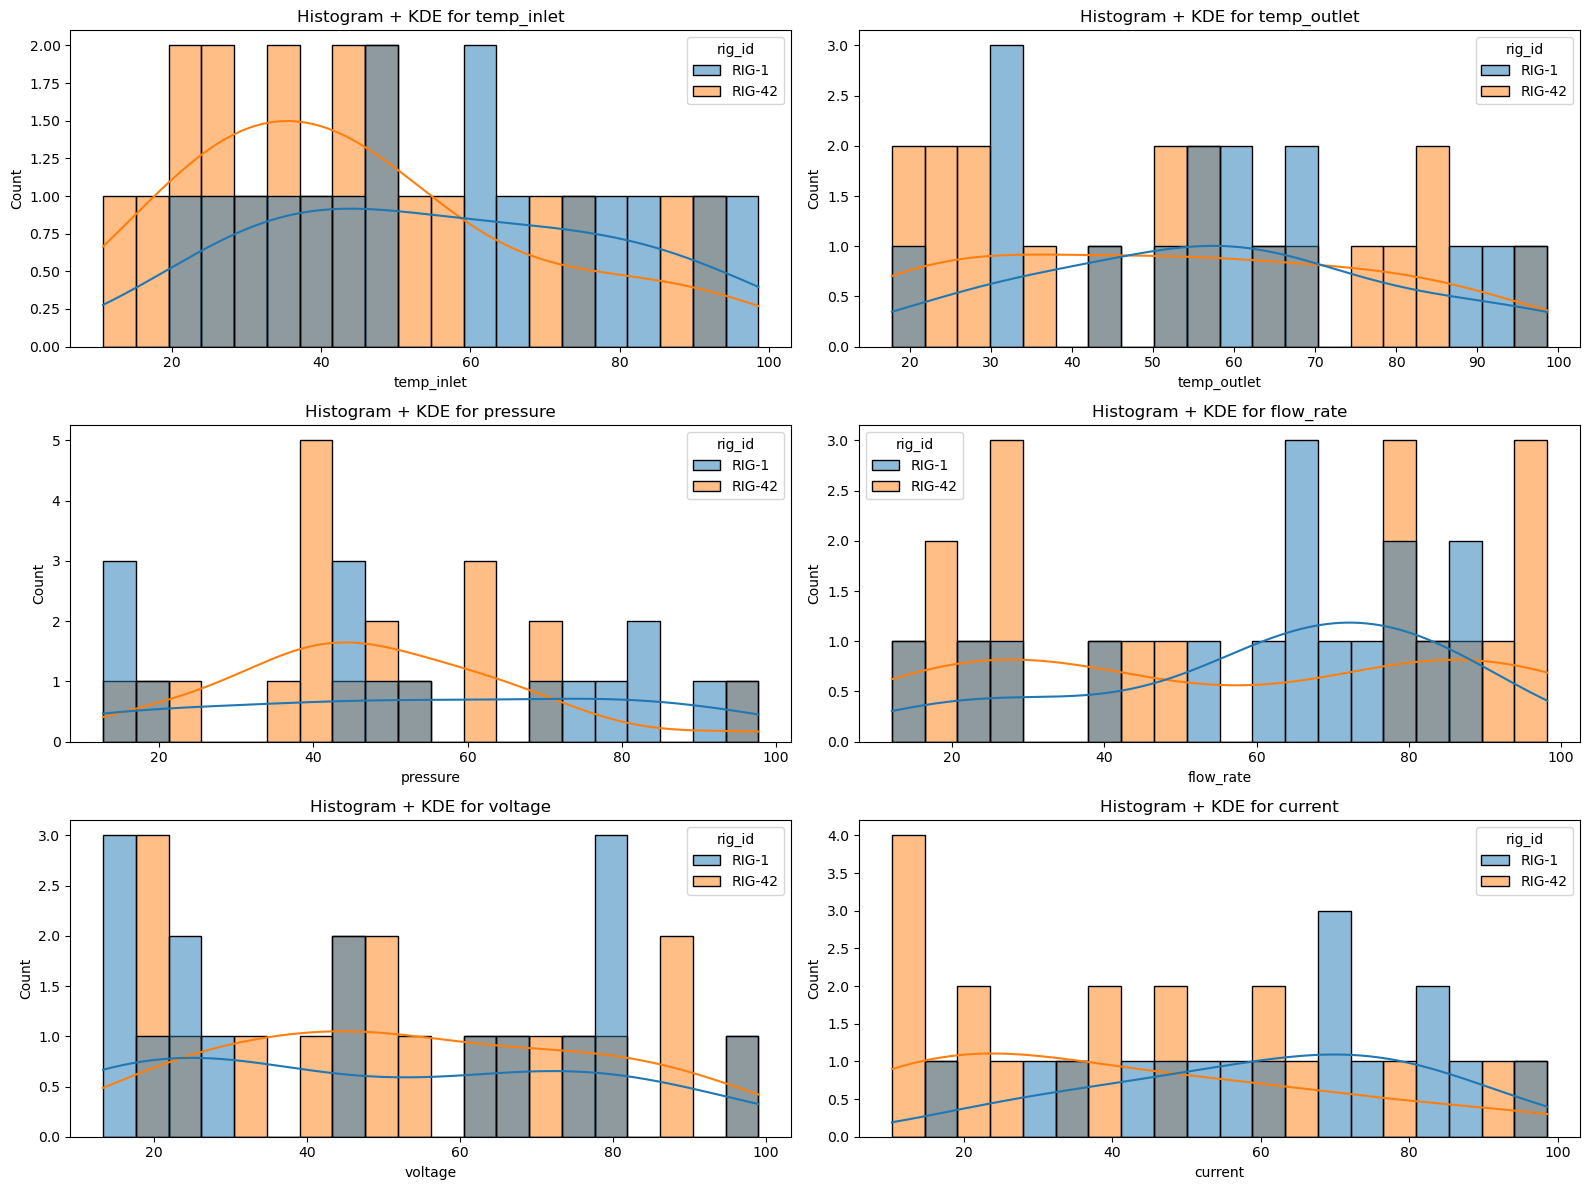

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sensors = ["temp_inlet", "temp_outlet", "pressure", "flow_rate", "voltage", "current"]

plt.figure(figsize=(16, 12))

for i, sensor in enumerate(sensors, 1):
    plt.subplot(3, 2, i)
    sns.histplot(
        df, x=sensor, hue="rig_id", kde=True, bins=20, palette="tab10", alpha=0.5
    )
    plt.title(f"Histogram + KDE for {sensor}")
    plt.xlabel(sensor)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()
